In [1]:

from pyspark.sql import SparkSession
from pyspark.ml.feature import IndexToString, VectorAssembler,StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.ml.feature import PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassifier


#spark = SparkSession.builder.getOrCreate()

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191206151449-0000
KERNEL_ID = 9e21ace1-6f45-493c-8765-06fcc073e932


In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:

from pyspark.sql.functions import col



spark_df=spark_df.select(*(col(c).cast("float").alias(c) for c in spark_df.columns[:]))

In [4]:
from pyspark.ml.feature import StandardScaler

names=spark_df.schema.names

(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 42)

si_Label = StringIndexer(inputCol="cat", outputCol="label").fit(spark_df)
va_features = VectorAssembler(inputCols=names[:-1], outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

In [5]:
# setting PCA dataset

pipe1=Pipeline(stages=[si_Label, va_features, scaler])
pipe1_fit=pipe1.fit(train_data)
pipe1_transform=pipe1_fit.transform(train_data)


In [7]:
d=1500
pca = PCA(k=d, inputCol="scaledFeatures", outputCol="pcaFeatures")

pca_model=pca.fit(pipe1_transform)

var_vector=pca_model.explainedVariance.toArray()

In [8]:
# Number of components selection
cum=0
for k,i in enumerate(var_vector):
    cum+=i
    if cum>=0.9:
        print(k+1)
        break
    

1290


In [9]:
pca_2 = PCA(k=k+1, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model_2=pca_2.fit(pipe1_transform)

transformed_feature = pca_model_2.transform(pipe1_transform)

#transformed_feature.show()

In [10]:
test_transformed=pipe1_fit.transform(test_data)
transformed_feature_test = pca_model_2.transform(test_transformed)

In [11]:

from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

classifier_rf = RandomForestClassifier(featuresCol="pcaFeatures")
classifier_svm=LinearSVC(featuresCol="pcaFeatures")

paramGrid_rf = ParamGridBuilder()\
    .addGrid(classifier_rf.maxBins, [5, 10]) \
    .addGrid(classifier_rf.maxDepth, [8,10])\
    .build()



tvs_rf = TrainValidationSplit(estimator=classifier_rf,
                           estimatorParamMaps=paramGrid_rf,
                           evaluator=MulticlassClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

model_rf = tvs_rf.fit(transformed_feature)




#transformed_feature_test.show()

In [12]:
#paramGrid_svm = ParamGridBuilder()\
#    .addGrid(classifier_svm.regParam, [0.1, 3,30]) \
#    .build()

"""
tvs_svm = TrainValidationSplit(estimator=classifier_svm,
                           estimatorParamMaps=paramGrid_svm,
                           evaluator=MulticlassClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
"""

model_svm=classifier_svm.fit(transformed_feature)

KeyboardInterrupt: 

In [13]:

predictions_rf = model_rf.transform(transformed_feature_test)


evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rf)
print("Accuracy = %f " % (accuracy))


Accuracy = 0.986728 


In [ ]:
predictions_svm = model_svm.transform(transformed_feature_test)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_svm)
print("Accuracy SVM = %f " % (accuracy))

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Let's use the run-of-the-mill evaluator
evaluator_bin = BinaryClassificationEvaluator(labelCol='label')

# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator_bin.evaluate(predictions_rf, {evaluator_bin.metricName: "areaUnderROC"})
auprc = evaluator_bin.evaluate(predictions_rf, {evaluator_bin.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.9946
Area under PR Curve: 0.9887


    100% |################################| 215kB 2.5MB/s eta 0:00:01
    100% |################################| 215.7MB 109kB/s eta 0:00:01   15% |#####                           | 33.9MB 58.1MB/s eta 0:00:04    84% |###########################     | 182.0MB 54.2MB/s eta 0:00:01
    100% |################################| 59.2MB 359kB/s eta 0:00:01
    100% |################################| 7.0MB 2.0MB/s eta 0:00:01
    100% |################################| 20.0MB 882kB/s eta 0:00:01
    100% |################################| 10.4MB 1.3MB/s eta 0:00:01
    100% |################################| 25.2MB 553kB/s eta 0:00:01
    100% |################################| 13.1MB 1.4MB/s eta 0:00:01
    100% |################################| 204kB 4.7MB/s eta 0:00:01
    100% |################################| 296kB 4.3MB/s eta 0:00:01
    100% |################################| 512kB 4.0MB/s eta 0:00:01
    100% |################################| 235kB 3.9MB/s eta 0:00:01
    100% |###

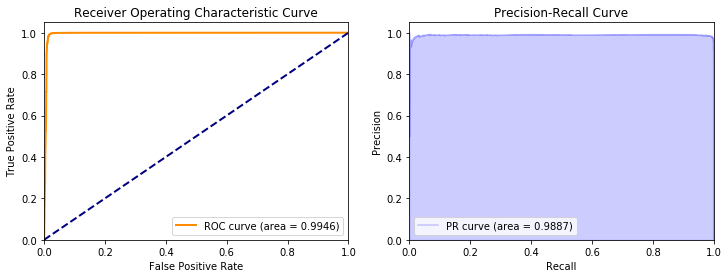

In [18]:
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
!pip install handyspark
from handyspark import *
# from the classifier
bcm = BinaryClassificationMetrics(predictions_rf, scoreCol='probability', labelCol='label')

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

